In [1]:
import warnings

warnings.filterwarnings('ignore')

# 2 基于geopandas的分层设色

## 2.1 基于mapclassify的数据分层

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams["font.family"] = "SimHei" # 设置全局中文字体为黑体

In [3]:
# 读入中国矢量数据
china = gpd.read_file('zip://china-shapefiles.zip!china-shapefiles',
                      layer='china',
                      encoding='utf-8')

# 由于每行数据是单独的面，因此按照其省份列OWNER融合
china = china.dissolve(by='OWNER').reset_index(drop=False)

# 读入南海九段线数据
nine_lines = gpd.read_file('zip://china-shapefiles.zip!china-shapefiles',
                           layer='china_nine_dotted_line',
                           encoding='utf-8')

# 读入2020-03-08更新的新冠肺炎原始数据
raw = pd.read_csv('DXYArea.csv', parse_dates=['updateTime'])

# 定义CRS
albers_proj = '+proj=aea +lat_1=25 +lat_2=47 +lon_0=105'

# 抽取updateTime列中的年、月、日信息分别保存到新列中
raw['year'], raw['month'], raw['day'] = list(zip(*raw['updateTime'].apply(lambda d: (d.year, d.month, d.day))))

# 得到每个省份最新的指标数据
temp = raw.sort_values(['provinceName', 'updateTime'], 
                ascending=False, 
                ignore_index=True).groupby('provinceName') \
                                  .first() \
                                  .reset_index(drop=False) \
                                  .loc[:, ['provinceName', 
                                           'provinceEnglishName',
                                           'province_confirmedCount',
                                           'province_suspectedCount',
                                           'province_curedCount',
                                           'province_deadCount']]

# 查看前5行
temp.head()

,provinceName,provinceEnglishName,province_confirmedCount,province_suspectedCount,province_curedCount,province_deadCount
0,上海市,Shanghai,342,0,314,3
1,云南省,Yunnan,174,0,170,2
2,内蒙古自治区,Neimenggu,75,0,70,1
3,北京市,Beijing,428,0,308,8
4,吉林省,Jilin,93,0,90,1


### 2.1.1 BoxPlot

In [4]:
import mapclassify as mc

# 对各省2020-03-04对应的累计确诊数量进行分层
bp = mc.BoxPlot(temp['province_confirmedCount'])
# 查看数据分层结果
bp

                   Box Plot                  
 
  Lower              Upper              Count
            x[i] <=  -682.250               0
 -682.250 < x[i] <=   124.750               8
  124.750 < x[i] <=   274.000               8
  274.000 < x[i] <=   662.750               8
  662.750 < x[i] <=  1469.750               7
 1469.750 < x[i] <= 67707.000               1

In [5]:
data_with_geometry = pd.merge(left=temp.replace('澳门', '澳门特别行政区'),
                              right=china,
                              left_on='provinceName',
                              right_on='OWNER',
                              how='right'
                              ).loc[:, ['provinceName',
                                        'provinceEnglishName',
                                        'province_confirmedCount',
                                        'province_suspectedCount',
                                        'province_curedCount',
                                        'province_deadCount',
                                        'geometry'
                                        ]]
# 将数据从DataFrame转换为GeoDataFrame
data_with_geometry = gpd.GeoDataFrame(data_with_geometry, crs='EPSG:4326')
data_with_geometry.head()

,provinceName,provinceEnglishName,province_confirmedCount,province_suspectedCount,province_curedCount,province_deadCount,geometry
0,上海市,Shanghai,342.0,0.0,314.0,3.0,"MULTIPOLYGON (((121.42117 30.68613, 121.42240 ..."
1,云南省,Yunnan,174.0,0.0,170.0,2.0,"POLYGON ((105.30025 27.70911, 105.29577 27.698..."
2,内蒙古自治区,Neimenggu,75.0,0.0,70.0,1.0,"POLYGON ((121.48938 53.33117, 121.49769 53.320..."
3,北京市,Beijing,428.0,0.0,308.0,8.0,"POLYGON ((117.37974 40.22687, 117.38528 40.223..."
4,吉林省,Jilin,93.0,0.0,90.0,1.0,"POLYGON ((123.17773 46.24767, 123.18046 46.248..."


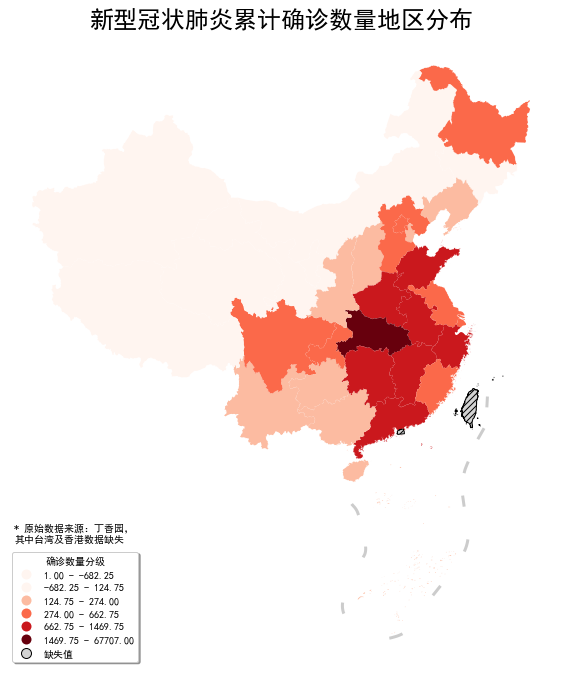

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

ax = data_with_geometry.to_crs(albers_proj).plot(ax=ax,
                                                 column='province_confirmedCount',
                                                 cmap='Reds',
                                                 missing_kwds={
                                                     "color": "lightgrey",
                                                     "edgecolor": "black",
                                                     "hatch": "////",
                                                     "label": "缺失值"
                                                 },
                                                 legend=True,
                                                 scheme='BoxPlot',
                                                 legend_kwds={
                                                     'loc': 'lower left',
                                                     'title': '确诊数量分级',
                                                     'shadow': True
                                                 })

ax = nine_lines.geometry.to_crs(albers_proj).plot(ax=ax,
                                                  edgecolor='grey',
                                                  linewidth=3,
                                                  alpha=0.4)

ax.axis('off')
plt.suptitle('新型冠状肺炎累计确诊数量地区分布', fontsize=24) # 添加最高级别标题
plt.tight_layout(pad=4.5) # 调整不同标题之间间距
ax.text(-2800000, 1300000, '* 原始数据来源：丁香园，\n其中台湾及香港数据缺失') # 添加数据说明

fig.savefig('图6.png', dpi=300)

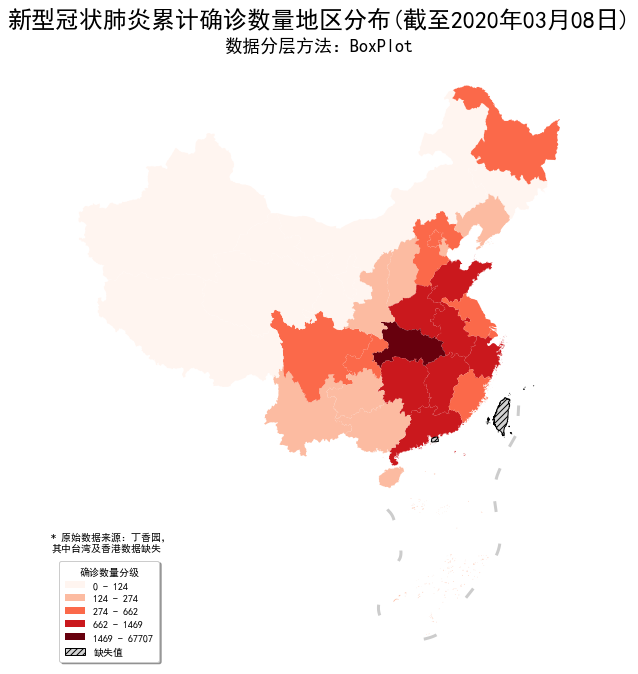

In [7]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 10))

ax = data_with_geometry.to_crs(albers_proj).plot(ax=ax,
                                                 column='province_confirmedCount',
                                                 cmap='Reds',
                                                 missing_kwds={
                                                     "color": "lightgrey",
                                                     "edgecolor": "black",
                                                     "hatch": "////",
                                                     "label": "缺失值"
                                                 },
                                                 scheme='BoxPlot')

handles, labels = ax.get_legend_handles_labels() #get existing legend item handles and labels

ax = nine_lines.geometry.to_crs(albers_proj).plot(ax=ax,
                                                  edgecolor='grey',
                                                  linewidth=3,
                                                  alpha=0.4)

# 实例化cmap方案
cmap = plt.get_cmap('Reds')

# 得到mapclassify中BoxPlot的数据分层点
bp = mc.BoxPlot(temp['province_confirmedCount'])
bins = bp.bins

# 制作图例映射对象列表
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{int(max(bins[_], 0))} - {int(bins[_+1])}') 
                 for _ in range(5)] + \
                [mpatches.Patch(facecolor='lightgrey', edgecolor='black', hatch='////', label='缺失值')]

# 将制作好的图例映射对象列表导入legend()中，并配置相关参数
ax.legend(handles = LegendElement, loc='lower left', fontsize=10, title='确诊数量分级', shadow=True, borderpad=0.6)

ax.axis('off')
plt.suptitle('新型冠状肺炎累计确诊数量地区分布(截至2020年03月08日)', fontsize=24) # 添加最高级别标题
plt.title('数据分层方法：BoxPlot', fontsize=18)
plt.tight_layout(pad=4.5) # 调整不同标题之间间距
ax.text(-2900000, 1250000, '* 原始数据来源：丁香园，\n其中台湾及香港数据缺失') # 添加数据说明

fig.savefig('图7.png', dpi=300)

### 2.1.2 EqualInterval

In [8]:
bp = mc.EqualInterval(temp['province_confirmedCount'])
# 查看数据分层结果
bp

                Equal Interval                
 
  Lower              Upper               Count
            x[i] <= 13542.200               31
13542.200 < x[i] <= 27083.400                0
27083.400 < x[i] <= 40624.600                0
40624.600 < x[i] <= 54165.800                0
54165.800 < x[i] <= 67707.000                1

### 2.1.3 FisherJenks

In [9]:
bp = mc.FisherJenks(temp['province_confirmedCount'])
# 查看数据分层结果
bp

                 FisherJenks                  
 
  Lower              Upper               Count
            x[i] <=   252.000               16
  252.000 < x[i] <=   631.000                8
  631.000 < x[i] <=  1018.000                4
 1018.000 < x[i] <=  1352.000                3
 1352.000 < x[i] <= 67707.000                1

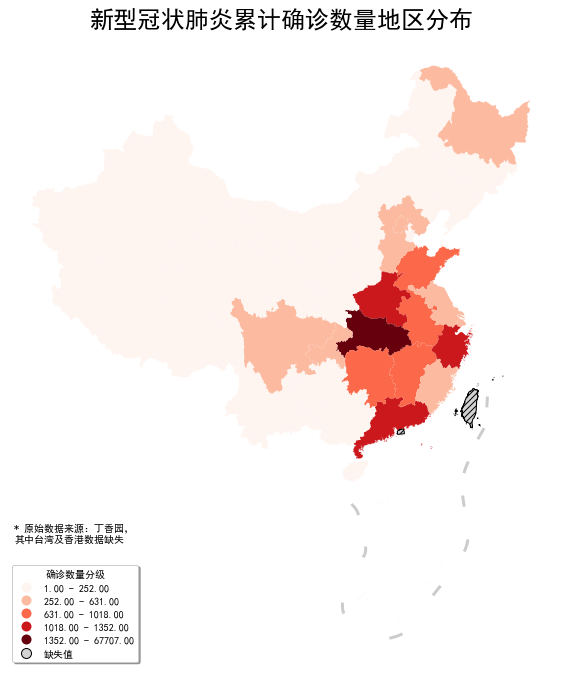

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

ax = data_with_geometry.to_crs(albers_proj).plot(ax=ax,
                                                 column='province_confirmedCount',
                                                 cmap='Reds',
                                                 missing_kwds={
                                                     "color": "lightgrey",
                                                     "edgecolor": "black",
                                                     "hatch": "////",
                                                     "label": "缺失值"
                                                 },
                                                 legend=True,
                                                 scheme='FisherJenks',
                                                 k=5,
                                                 legend_kwds={
                                                     'loc': 'lower left',
                                                     'title': '确诊数量分级',
                                                     'shadow': True
                                                 })

ax = nine_lines.geometry.to_crs(albers_proj).plot(ax=ax,
                                                  edgecolor='grey',
                                                  linewidth=3,
                                                  alpha=0.4)

ax.axis('off')
plt.suptitle('新型冠状肺炎累计确诊数量地区分布', fontsize=24) # 添加最高级别标题
plt.tight_layout(pad=4.5) # 调整不同标题之间间距
ax.text(-2800000, 1300000, '* 原始数据来源：丁香园，\n其中台湾及香港数据缺失') # 添加数据说明

fig.savefig('图10.png', dpi=300)

### 2.1.4 NaturalBreaks

In [11]:
bp = mc.NaturalBreaks(temp['province_confirmedCount'])
# 查看数据分层结果
bp

                NaturalBreaks                 
 
  Lower              Upper               Count
            x[i] <=   252.000               16
  252.000 < x[i] <=   631.000                8
  631.000 < x[i] <=  1018.000                4
 1018.000 < x[i] <=  1352.000                3
 1352.000 < x[i] <= 67707.000                1

### 2.1.5 JenksCaspall

- **基于mapclassify的源代码解释JenksCaspall**

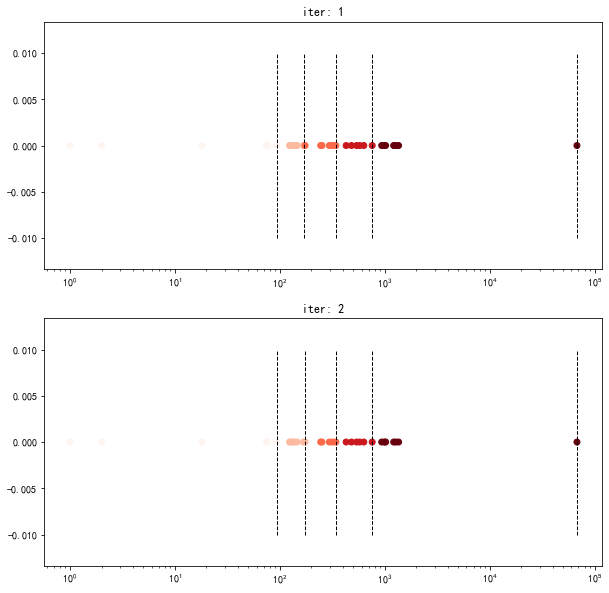

In [12]:
import numpy as np
from scipy import stats
import scipy as sp

def quantile(y, k=4):
    """
    Calculates the quantiles for an array

    Parameters
    ----------
    y : array
        (n,1), values to classify
    k : int
        number of quantiles

    Returns
    -------
    q         : array
                (n,1), quantile values

    Examples
    --------
    >>> import numpy as np
    >>> import mapclassify as mc
    >>> x = np.arange(1000)
    >>> mc.classifiers.quantile(x)
    array([249.75, 499.5 , 749.25, 999.  ])
    >>> mc.classifiers.quantile(x, k = 3)
    array([333., 666., 999.])

    Note that if there are enough ties that the quantile values repeat, we
    collapse to pseudo quantiles in which case the number of classes will be
    less than k

    >>> x = [1.0] * 100
    >>> x.extend([3.0] * 40)
    >>> len(x)
    140
    >>> y = np.array(x)
    >>> mc.classifiers.quantile(y)
    array([1., 3.])
    """

    w = 100.0 / k
    p = np.arange(w, 100 + w, w)
    if p[-1] > 100.0:
        p[-1] = 100.0
    q = np.array([stats.scoreatpercentile(y, pct) for pct in p])
    q = np.unique(q)
    k_q = len(q)
    if k_q < k:
        Warn(
            "Warning: Not enough unique values in array to form k classes", UserWarning
        )
        Warn("Warning: setting k to %d" % k_q, UserWarning)
    return q

def bin1d(x, bins):
    """
    Place values of a 1-d array into bins and determine counts of values in
    each bin

    Parameters
    ----------
    x : array
        (n, 1), values to bin
    bins : array
           (k,1), upper bounds of each bin (monotonic)

    Returns
    -------
    binIds : array
             1-d array of integer bin Ids

    counts : int
            number of elements of x falling in each bin

    Examples
    --------
    >>> import numpy as np
    >>> import mapclassify as mc
    >>> x = np.arange(100, dtype = 'float')
    >>> bins = [25, 74, 100]
    >>> binIds, counts = mc.classifiers.bin1d(x, bins)
    >>> binIds
    array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
           2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
    >>> counts
    array([26, 49, 25])
    """
    left = [-float("inf")]
    left.extend(bins[0:-1])
    right = bins
    cuts = list(zip(left, right))
    k = len(bins)
    binIds = np.zeros(x.shape, dtype="int")
    while cuts:
        k -= 1
        l, r = cuts.pop(-1)
        binIds += (x > l) * (x <= r) * k
    counts = np.bincount(binIds, minlength=len(bins))
    return (binIds, counts)

x = temp['province_confirmedCount'].values.copy()
x.sort()

k = 5
# start with quantiles
q = quantile(x, k)
solving = True
xb, cnts = bin1d(x, q)
# class means
if x.ndim == 1:
    x.shape = (x.size, 1)
xm = [np.median(x[xb == i]) for i in np.unique(xb)]
xb0 = xb.copy()
q = xm
it = 0
rk = list(range(k))
rk

plot_y = []

while solving:
    plot_y.append(xb.copy())
    xb = np.zeros(xb0.shape, int)
    d = abs(x - q)
    xb = d.argmin(axis=1)
    if (xb0 == xb).all():
        solving = False
    else:
        xb0 = xb
    it += 1
    
    q = np.array([np.median(x[xb == i]) for i in rk])
cuts = np.array([max(x[xb == i]) for i in sp.unique(xb)])
cuts.shape = (len(cuts),)
it

plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

fig, axes = plt.subplots(nrows=plot_y.__len__(), figsize=(10, 10))

for _ in range(axes.__len__()):
    axes[_].scatter(x=x, y=[0 for i in range(x.__len__())], c=plot_y[_], cmap='Reds')
    for v_line in np.array([max(x[plot_y[_] == i]) for i in sp.unique(plot_y[_])]).flatten():
        axes[_].vlines(v_line, ymin=-0.01, ymax=0.01, linestyle='--', linewidth=1)
    axes[_].set_xscale("log")
    axes[_].title.set_text(f'iter: {_+1}')
    
fig.savefig(fname='图14', dpi=300)

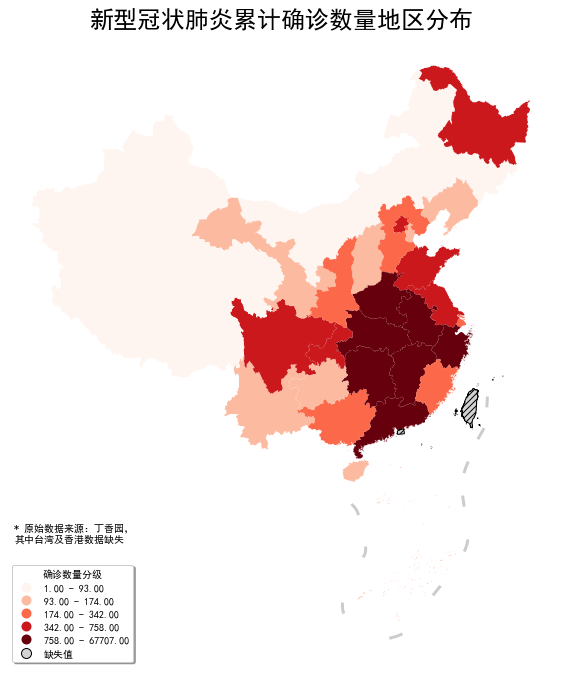

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

ax = data_with_geometry.to_crs(albers_proj).plot(ax=ax,
                                                 column='province_confirmedCount',
                                                 cmap='Reds',
                                                 missing_kwds={
                                                     "color": "lightgrey",
                                                     "edgecolor": "black",
                                                     "hatch": "////",
                                                     "label": "缺失值"
                                                 },
                                                 legend=True,
                                                 scheme='JenksCaspall',
                                                 k=5,
                                                 legend_kwds={
                                                     'loc': 'lower left',
                                                     'title': '确诊数量分级',
                                                     'shadow': True
                                                 })

ax = nine_lines.geometry.to_crs(albers_proj).plot(ax=ax,
                                                  edgecolor='grey',
                                                  linewidth=3,
                                                  alpha=0.4)

ax.axis('off')
plt.suptitle('新型冠状肺炎累计确诊数量地区分布', fontsize=24) # 添加最高级别标题
plt.tight_layout(pad=4.5) # 调整不同标题之间间距
ax.text(-2800000, 1300000, '* 原始数据来源：丁香园，\n其中台湾及香港数据缺失') # 添加数据说明

fig.savefig('图15.png', dpi=300)

### 2.1.6 HeadTailBreaks

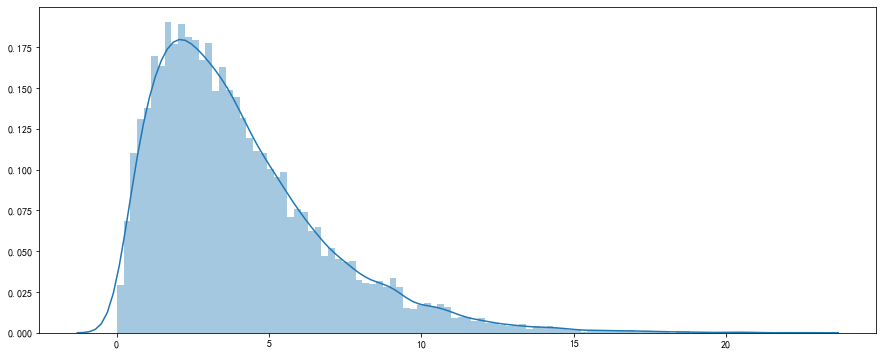

In [14]:
import numpy as np
import seaborn as sns

cal = np.random.chisquare(4, 10000)
plt.figure(figsize=(15, 6))
sns.distplot(cal, bins=100)
plt.savefig(fname='图16.png', dpi=300)

### 2.1.7 Quantiles

In [15]:
bp = mc.Quantiles(temp['province_confirmedCount'], k=5)
# 查看数据分层结果
bp

                  Quantiles                  
 
  Lower              Upper              Count
            x[i] <=    99.200               7
   99.200 < x[i] <=   170.400               6
  170.400 < x[i] <=   393.600               6
  393.600 < x[i] <=   899.600               6
  899.600 < x[i] <= 67707.000               7

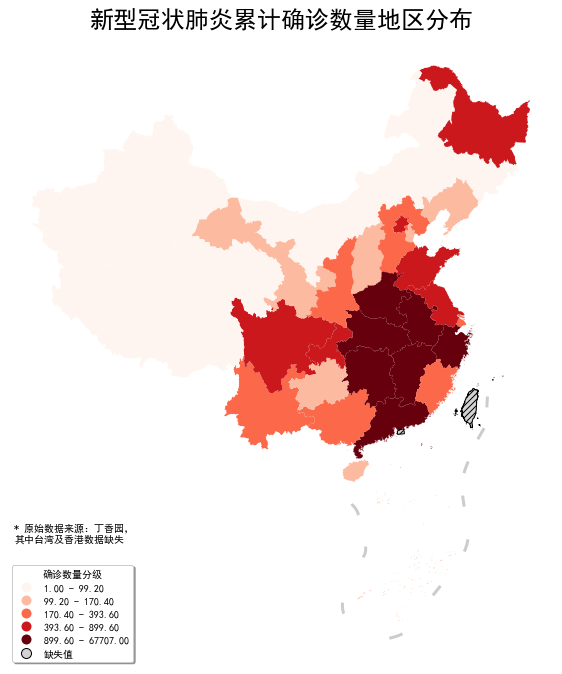

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

ax = data_with_geometry.to_crs(albers_proj).plot(ax=ax,
                                                 column='province_confirmedCount',
                                                 cmap='Reds',
                                                 missing_kwds={
                                                     "color": "lightgrey",
                                                     "edgecolor": "black",
                                                     "hatch": "////",
                                                     "label": "缺失值"
                                                 },
                                                 legend=True,
                                                 scheme='Quantiles',
                                                 k=5,
                                                 legend_kwds={
                                                     'loc': 'lower left',
                                                     'title': '确诊数量分级',
                                                     'shadow': True
                                                 })

ax = nine_lines.geometry.to_crs(albers_proj).plot(ax=ax,
                                                  edgecolor='grey',
                                                  linewidth=3,
                                                  alpha=0.4)

ax.axis('off')
plt.suptitle('新型冠状肺炎累计确诊数量地区分布', fontsize=24) # 添加最高级别标题
plt.tight_layout(pad=4.5) # 调整不同标题之间间距
ax.text(-2800000, 1300000, '* 原始数据来源：丁香园，\n其中台湾及香港数据缺失') # 添加数据说明

fig.savefig('图19.png', dpi=300)

### 2.1.8 Percentiles

In [17]:
bp = mc.Percentiles(temp['province_confirmedCount'],
                    pct=[1, 50, 99, 100])
# 查看数据分层结果
bp

                 Percentiles                  
 
  Lower              Upper               Count
            x[i] <=     1.310                1
    1.310 < x[i] <=   274.000               15
  274.000 < x[i] <= 47136.950               15
47136.950 < x[i] <= 67707.000                1

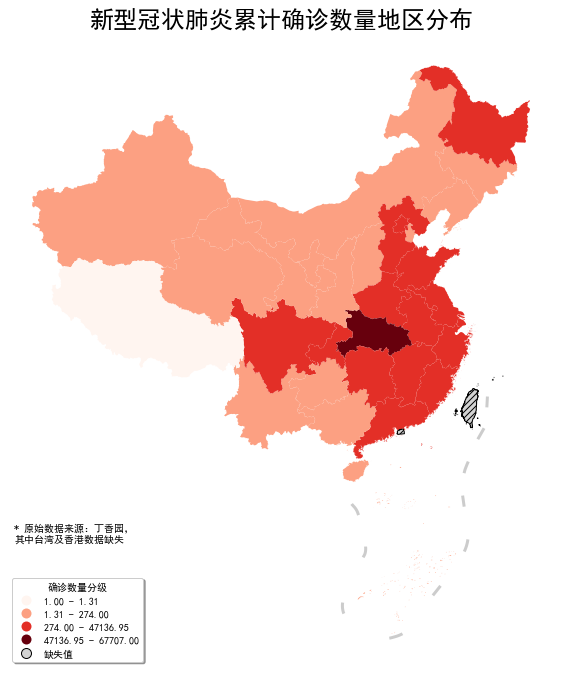

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))

ax = data_with_geometry.to_crs(albers_proj).plot(ax=ax,
                                                 column='province_confirmedCount',
                                                 cmap='Reds',
                                                 missing_kwds={
                                                     "color": "lightgrey",
                                                     "edgecolor": "black",
                                                     "hatch": "////",
                                                     "label": "缺失值"
                                                 },
                                                 legend=True,
                                                 scheme='Percentiles',
                                                 classification_kwds={
                                                     'pct': [1, 50, 99, 100]
                                                 },
                                                 legend_kwds={
                                                     'loc': 'lower left',
                                                     'title': '确诊数量分级',
                                                     'shadow': True
                                                 })

ax = nine_lines.geometry.to_crs(albers_proj).plot(ax=ax,
                                                  edgecolor='grey',
                                                  linewidth=3,
                                                  alpha=0.4)

ax.axis('off')
plt.suptitle('新型冠状肺炎累计确诊数量地区分布', fontsize=24) # 添加最高级别标题
plt.tight_layout(pad=4.5) # 调整不同标题之间间距
ax.text(-2800000, 1300000, '* 原始数据来源：丁香园，\n其中台湾及香港数据缺失') # 添加数据说明

fig.savefig('图21.png', dpi=300)

### 2.1.9 StdMean

In [19]:
bp = mc.StdMean(temp['province_confirmedCount'])
# 查看数据分层结果
bp

                    StdMean                     
 
  Lower                Upper               Count
             x[i] <= -21281.433                0
-21281.433 < x[i] <=  -9379.764                0
 -9379.764 < x[i] <=  14423.576               31
 14423.576 < x[i] <=  26325.246                0
 26325.246 < x[i] <=  67707.000                1

### 2.1.10 UserDefined

In [20]:
bp = mc.UserDefined(temp['province_confirmedCount'],
                    bins=[9, 99, 499, 999, 9999])
# 查看数据分层结果
bp

                 UserDefined                  
 
  Lower              Upper               Count
            x[i] <=     9.000                2
    9.000 < x[i] <=    99.000                5
   99.000 < x[i] <=   499.000               14
  499.000 < x[i] <=   999.000                6
  999.000 < x[i] <=  9999.000                4
 9999.000 < x[i] <= 67707.000                1

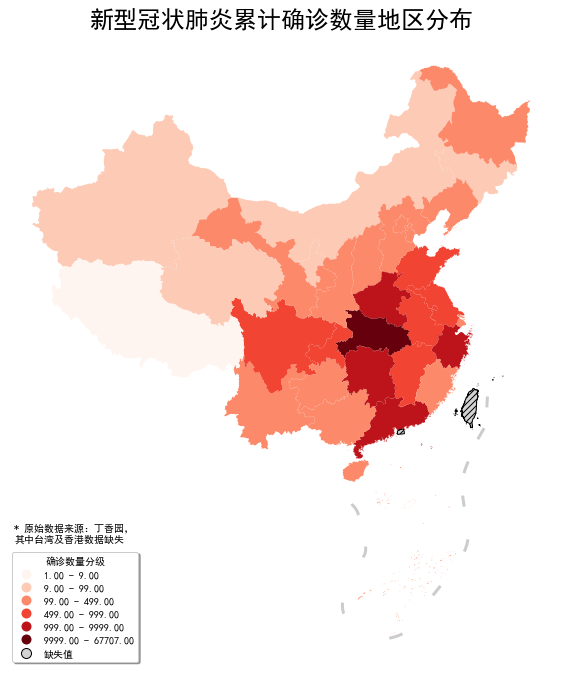

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))

ax = data_with_geometry.to_crs(albers_proj).plot(ax=ax,
                                                 column='province_confirmedCount',
                                                 cmap='Reds',
                                                 missing_kwds={
                                                     "color": "lightgrey",
                                                     "edgecolor": "black",
                                                     "hatch": "////",
                                                     "label": "缺失值"
                                                 },
                                                 legend=True,
                                                 scheme='UserDefined',
                                                 classification_kwds={
                                                     'bins': [9, 99, 499, 999, 9999]
                                                 },
                                                 legend_kwds={
                                                     'loc': 'lower left',
                                                     'title': '确诊数量分级',
                                                     'shadow': True
                                                 })

ax = nine_lines.geometry.to_crs(albers_proj).plot(ax=ax,
                                                  edgecolor='grey',
                                                  linewidth=3,
                                                  alpha=0.4)

ax.axis('off')
plt.suptitle('新型冠状肺炎累计确诊数量地区分布', fontsize=24) # 添加最高级别标题
plt.tight_layout(pad=4.5) # 调整不同标题之间间距
ax.text(-2800000, 1300000, '* 原始数据来源：丁香园，\n其中台湾及香港数据缺失') # 添加数据说明

fig.savefig('图24.png', dpi=300)

## 2.2 色彩方案的选择

### 2.2.1 基于palettable的配色

对应离散颜色：
[[230, 241, 241],
 [208, 230, 233],
 [185, 218, 228],
 [165, 207, 226],
 [146, 195, 226],
 [131, 182, 227],
 [120, 168, 228],
 [116, 154, 228],
 [116, 138, 226],
 [118, 121, 218],
 [120, 106, 208],
 [121, 90, 193],
 [120, 76, 177],
 [117, 62, 159],
 [112, 49, 138],
 [106, 38, 117],
 [96, 28, 94],
 [85, 22, 73],
 [70, 18, 52],
 [54, 14, 36]]
离散：


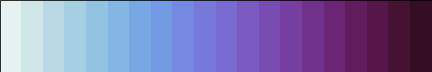

连续:


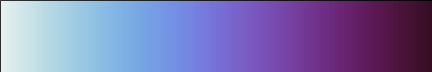

In [22]:
from palettable.cmocean.sequential import Dense_20
from pprint import pprint

print('对应离散颜色：')
pprint(Dense_20.colors)
print('离散：')
Dense_20.show_discrete_image()
print('连续:')
Dense_20.show_continuous_image()

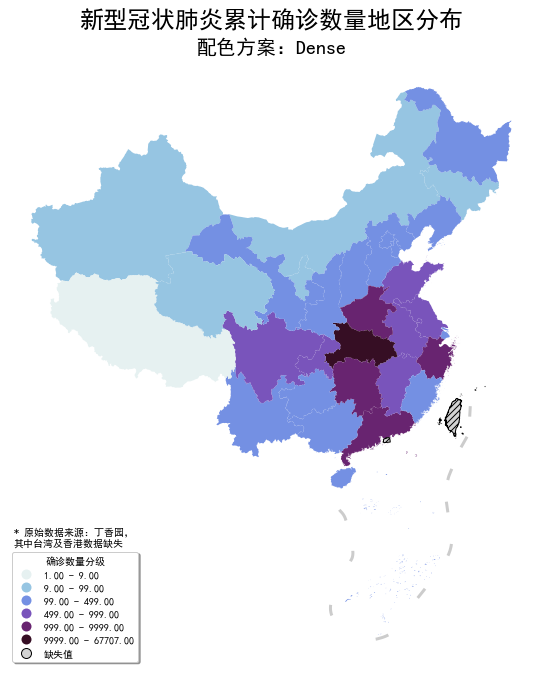

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))

ax = data_with_geometry.to_crs(albers_proj).plot(ax=ax,
                                                 column='province_confirmedCount',
                                                 cmap=Dense_20.mpl_colormap,
                                                 missing_kwds={
                                                     "color": "lightgrey",
                                                     "edgecolor": "black",
                                                     "hatch": "////",
                                                     "label": "缺失值"
                                                 },
                                                 legend=True,
                                                 scheme='UserDefined',
                                                 classification_kwds={
                                                     'bins': [9, 99, 499, 999, 9999]
                                                 },
                                                 legend_kwds={
                                                     'loc': 'lower left',
                                                     'title': '确诊数量分级',
                                                     'shadow': True
                                                 })

ax = nine_lines.geometry.to_crs(albers_proj).plot(ax=ax,
                                                  edgecolor='grey',
                                                  linewidth=3,
                                                  alpha=0.4)

ax.axis('off')
plt.suptitle('新型冠状肺炎累计确诊数量地区分布', fontsize=24) # 添加最高级别标题
plt.title('配色方案：Dense', fontsize=20)
plt.tight_layout(pad=4.5) # 调整不同标题之间间距
ax.text(-2800000, 1300000, '* 原始数据来源：丁香园，\n其中台湾及香港数据缺失') # 添加数据说明

fig.savefig('图28.png', dpi=300)

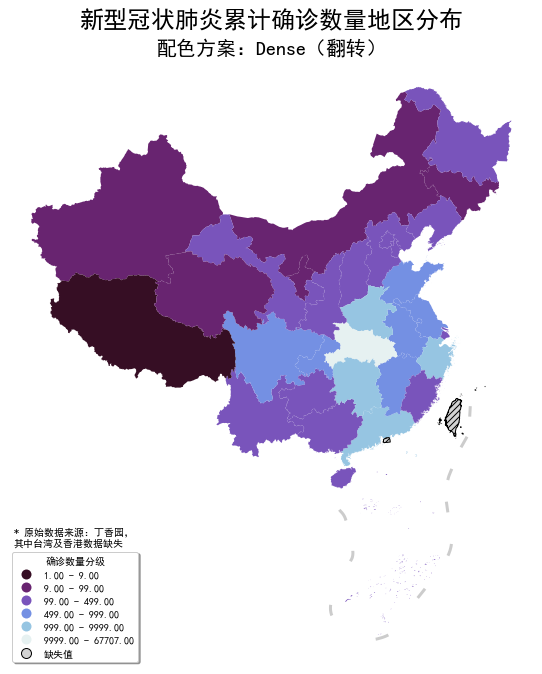

In [24]:
from palettable.cmocean.sequential import Dense_20_r

fig, ax = plt.subplots(figsize=(10, 10))

ax = data_with_geometry.to_crs(albers_proj).plot(ax=ax,
                                                 column='province_confirmedCount',
                                                 cmap=Dense_20_r.mpl_colormap,
                                                 missing_kwds={
                                                     "color": "lightgrey",
                                                     "edgecolor": "black",
                                                     "hatch": "////",
                                                     "label": "缺失值"
                                                 },
                                                 legend=True,
                                                 scheme='UserDefined',
                                                 classification_kwds={
                                                     'bins': [9, 99, 499, 999, 9999]
                                                 },
                                                 legend_kwds={
                                                     'loc': 'lower left',
                                                     'title': '确诊数量分级',
                                                     'shadow': True
                                                 })

ax = nine_lines.geometry.to_crs(albers_proj).plot(ax=ax,
                                                  edgecolor='grey',
                                                  linewidth=3,
                                                  alpha=0.4)

ax.axis('off')
plt.suptitle('新型冠状肺炎累计确诊数量地区分布', fontsize=24) # 添加最高级别标题
plt.title('配色方案：Dense（翻转）', fontsize=20)
plt.tight_layout(pad=4.5) # 调整不同标题之间间距
ax.text(-2800000, 1300000, '* 原始数据来源：丁香园，\n其中台湾及香港数据缺失') # 添加数据说明

fig.savefig('图29.png', dpi=300)

### 2.2.2 基于图片主色的配色

(-0.5, 599.5, 855.5, -0.5)

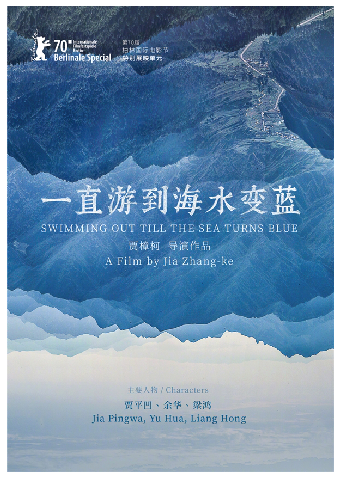

In [25]:
sea = plt.imread('一直游到海水变蓝_中文版.jpg')
fig, ax = plt.subplots(figsize=(6, 8.56)) # 根据图片原始分辨率比例设置合适画幅
ax.imshow(sea)
ax.axis('off')

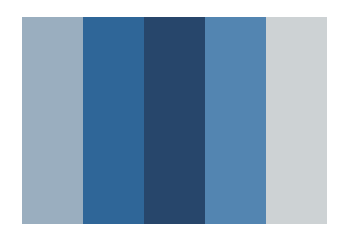

In [26]:
from sklearn.cluster import KMeans

# 构建特征
rgb = pd.DataFrame([sea[x][y] for x in range(sea.shape[0]) for y in range(sea.shape[1])],
             columns=['r', 'g', 'b'])

# k-means聚类，其中n_clusters表示聚类数量，n_jobs=-1表示开启所有核心并行运算
model = KMeans(n_clusters=5, n_jobs=-1)
model.fit(rgb) # 训练模型

# 提取聚类簇重心，即我们需要的主色，绘制调色板
plt.bar([i for i in range(model.cluster_centers_.__len__())], 
        height=[1 for i in range(model.cluster_centers_.__len__())],
        color=[tuple(c) for c in (model.cluster_centers_ / 255.)],
        width=1)
plt.axis('off')
plt.savefig('图31.png', dpi=300)

(-0.5, 639.5, 905.5, -0.5)

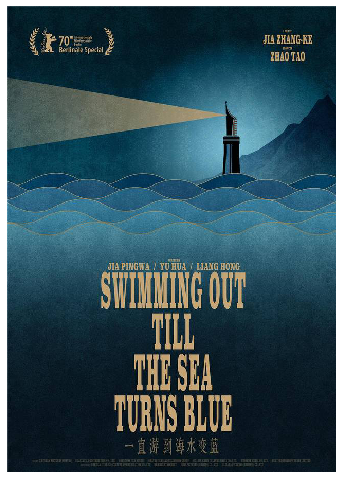

In [27]:
sea = plt.imread('一直游到海水变蓝_海外版.jpg')
fig, ax = plt.subplots(figsize=(6, 8.56)) # 根据图片原始分辨率比例设置合适画幅
ax.imshow(sea)
ax.axis('off')

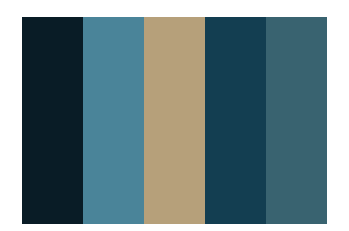

In [28]:
from sklearn.cluster import KMeans

# 构建特征
rgb = pd.DataFrame([sea[x][y] for x in range(sea.shape[0]) for y in range(sea.shape[1])],
             columns=['r', 'g', 'b'])

# k-means聚类，其中n_clusters表示聚类数量，n_jobs=-1表示开启所有核心并行运算
model = KMeans(n_clusters=5, n_jobs=-1)
model.fit(rgb) # 训练模型

# 提取聚类簇重心，即我们需要的主色，绘制调色板
plt.bar([i for i in range(model.cluster_centers_.__len__())], 
        height=[1 for i in range(model.cluster_centers_.__len__())],
        color=[tuple(c) for c in (model.cluster_centers_ / 255.)],
        width=1)
plt.axis('off')
plt.savefig('图33.png', dpi=300)